# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0+cu101


In [ ]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/deeplearning/')
sys.path.append(str(base))

Mounted at /content/drive


# Preparing Training and Test Sets

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/content/drive/My Drive/deeplearning/covid-scans/'
source_dirs = ['normal', 'viral', 'covid']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c)) #create the test set with equal amount from each class

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 100) #test set of 500 per class
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self,image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names =['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') #using pretrained weights that require RGB
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
test_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Prepare DataLoader

In [1]:
train_dirs = {
    'normal': '/content/gdrive/MyDrive/deeplearning/covid-scans/torch/normal',
    'viral': '/content/gdrive/MyDrive/deeplearning/covid-scans/torch/viral',
    'covid': '/content/gdrive/MyDrive/deeplearning/covid-scans/torch/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_trans)

NameError: ignored

In [ ]:
test_dirs = {
    'normal': '/content/drive/My Drive/deeplearning/covid-scans/test/normal',
    'viral': '/content/drive/My Drive/deeplearning/covid-scans/test/viral',
    'covid': '/content/drive/My Drive/deeplearning/covid-scans/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_trans)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 281
Number of test batches 50


# Data Visualization

In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1,6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0)) #channel first changed to channel last
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array ([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'blue' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

        
        

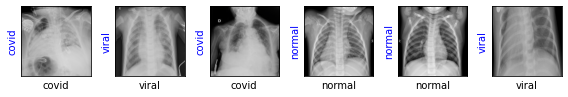

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

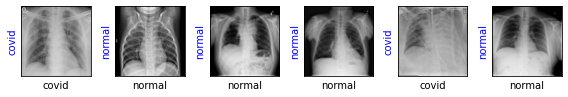

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features = 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs,1)
    show_images(images, labels, preds)

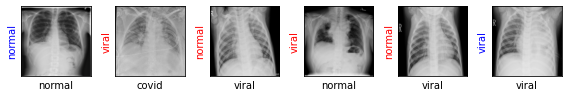

In [ ]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0,epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        val_loss = 0
        
        resnet18.train()
        
        for train_step, (images,labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs= resnet18(images)
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print("Evaluating at step", train_step)
                acc = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum(preds == labels).numpy()
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.99:
                    print('Performance condition has been satisfied')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/10
Evaluating at step 0
Val loss: 0.1576, Acc: 0.9400


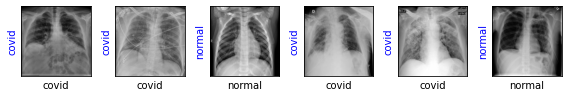

Evaluating at step 20
Val loss: 0.1497, Acc: 0.9433


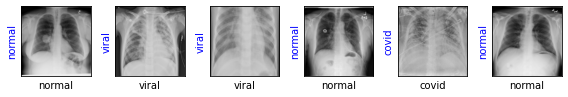

Evaluating at step 40
Val loss: 0.1878, Acc: 0.9200


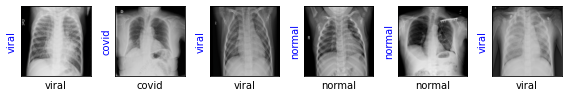

Evaluating at step 60
Val loss: 0.0990, Acc: 0.9667


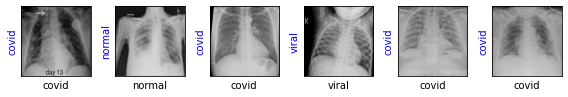

Evaluating at step 80
Val loss: 0.1386, Acc: 0.9433


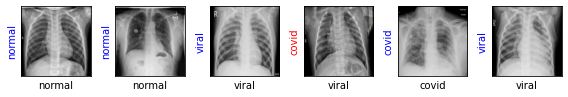

Evaluating at step 100
Val loss: 0.1479, Acc: 0.9533


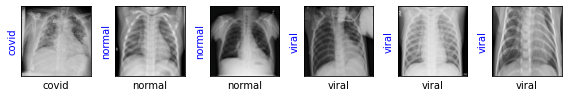

Evaluating at step 120
Val loss: 0.1258, Acc: 0.9567


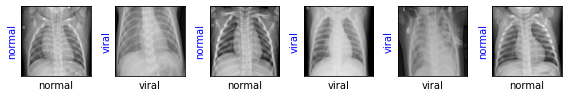

Evaluating at step 140
Val loss: 0.1546, Acc: 0.9400


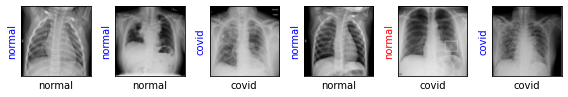

Evaluating at step 160
Val loss: 0.1172, Acc: 0.9600


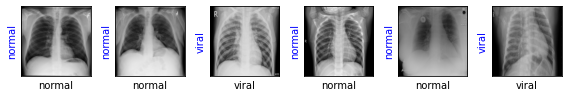

Evaluating at step 180
Val loss: 0.1335, Acc: 0.9567


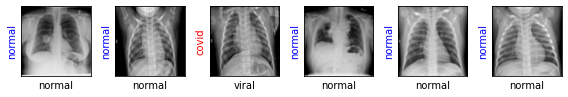

Evaluating at step 200
Val loss: 0.1024, Acc: 0.9700


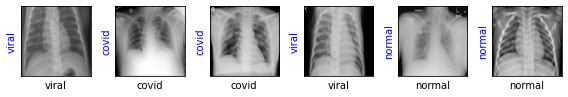

Evaluating at step 220
Val loss: 0.1397, Acc: 0.9467


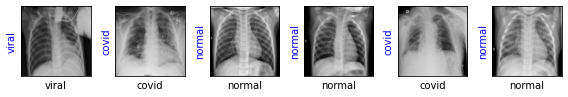

Evaluating at step 240
Val loss: 0.1218, Acc: 0.9633


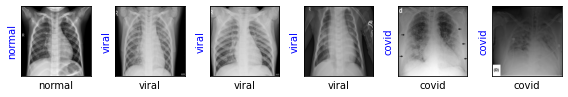

Evaluating at step 260
Val loss: 0.0906, Acc: 0.9733


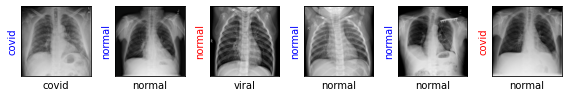

Evaluating at step 280
Val loss: 0.1026, Acc: 0.9600


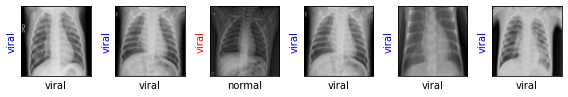

Training loss: 0.2318
Starting epoch 2/10
Evaluating at step 0
Val loss: 0.0993, Acc: 0.9667


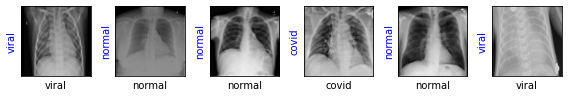

Evaluating at step 20
Val loss: 0.0809, Acc: 0.9733


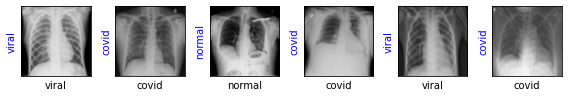

Evaluating at step 40
Val loss: 0.1023, Acc: 0.9700


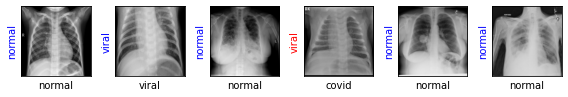

Evaluating at step 60
Val loss: 0.1472, Acc: 0.9533


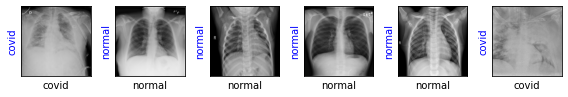

Evaluating at step 80
Val loss: 0.1076, Acc: 0.9600


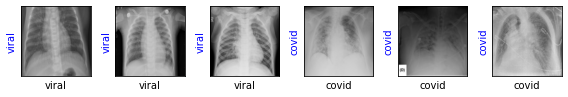

Evaluating at step 100
Val loss: 0.0931, Acc: 0.9733


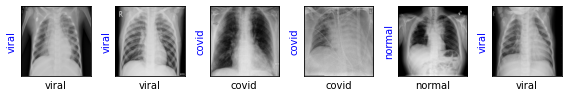

Evaluating at step 120
Val loss: 0.0975, Acc: 0.9633


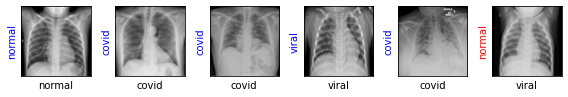

Evaluating at step 140
Val loss: 0.0985, Acc: 0.9667


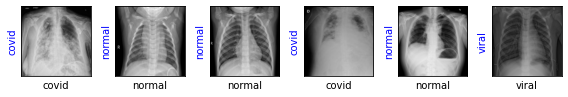

Evaluating at step 160
Val loss: 0.0876, Acc: 0.9733


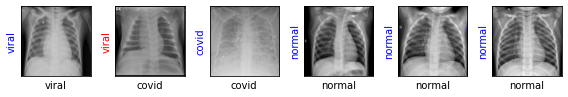

Evaluating at step 180
Val loss: 0.0995, Acc: 0.9600


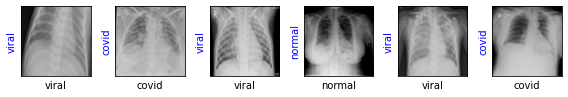

Evaluating at step 200
Val loss: 0.1363, Acc: 0.9567


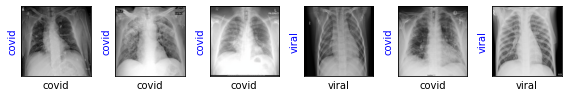

Evaluating at step 220
Val loss: 0.0681, Acc: 0.9700


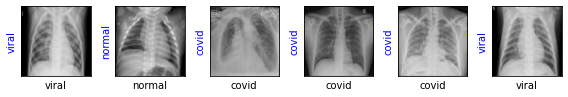

Evaluating at step 240
Val loss: 0.0789, Acc: 0.9800


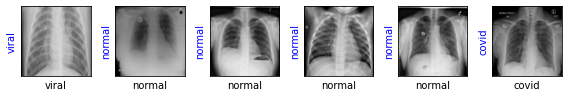

Evaluating at step 260
Val loss: 0.0805, Acc: 0.9767


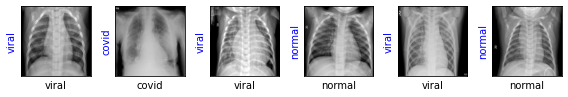

Evaluating at step 280
Val loss: 0.1065, Acc: 0.9567


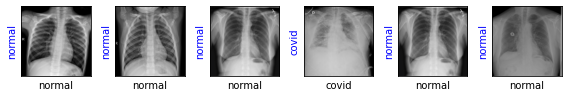

Training loss: 0.1679
Starting epoch 3/10
Evaluating at step 0
Val loss: 0.1155, Acc: 0.9600


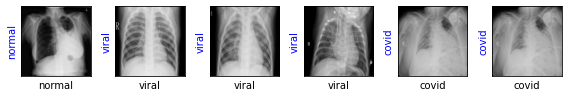

Evaluating at step 20
Val loss: 0.0877, Acc: 0.9700


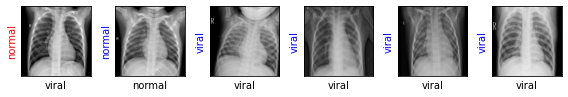

Evaluating at step 40
Val loss: 0.0704, Acc: 0.9800


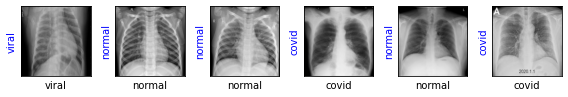

Evaluating at step 60
Val loss: 0.1112, Acc: 0.9600


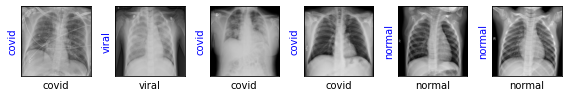

Evaluating at step 80
Val loss: 0.0480, Acc: 0.9900


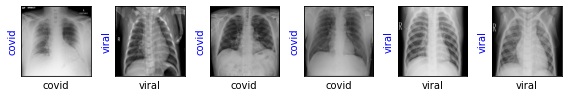

Evaluating at step 100
Val loss: 0.1106, Acc: 0.9567


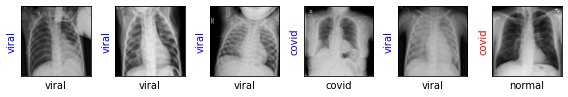

Evaluating at step 120
Val loss: 0.0854, Acc: 0.9667


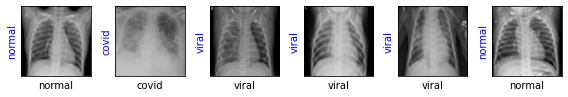

Evaluating at step 140
Val loss: 0.0700, Acc: 0.9733


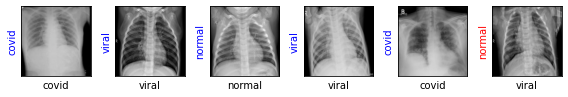

Evaluating at step 160
Val loss: 0.0797, Acc: 0.9800


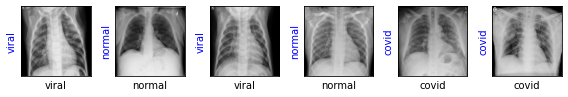

Evaluating at step 180
Val loss: 0.0685, Acc: 0.9833


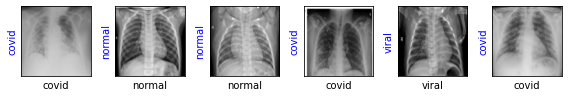

Evaluating at step 200
Val loss: 0.0598, Acc: 0.9833


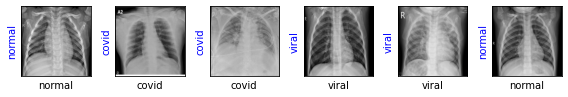

Evaluating at step 220
Val loss: 0.0921, Acc: 0.9533


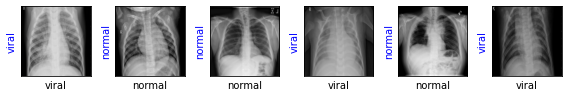

Evaluating at step 240
Val loss: 0.0491, Acc: 0.9833


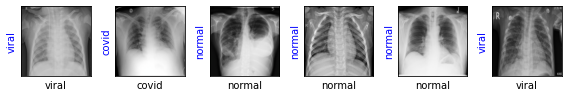

Evaluating at step 260
Val loss: 0.0780, Acc: 0.9800


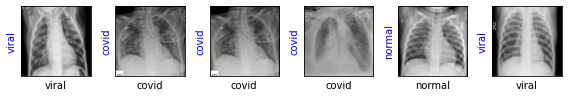

Evaluating at step 280
Val loss: 0.0690, Acc: 0.9767


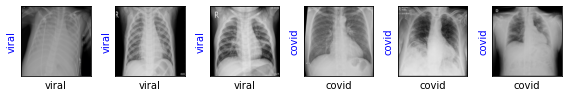

Training loss: 0.0961
Starting epoch 4/10
Evaluating at step 0
Val loss: 0.0704, Acc: 0.9833


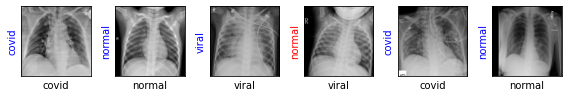

Evaluating at step 20
Val loss: 0.1392, Acc: 0.9467


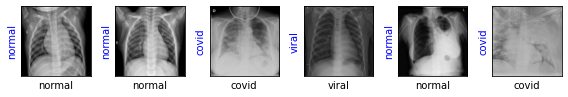

Evaluating at step 40
Val loss: 0.1192, Acc: 0.9533


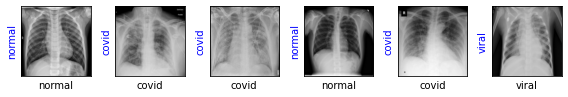

Evaluating at step 60
Val loss: 0.1046, Acc: 0.9667


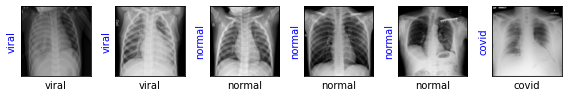

Evaluating at step 80
Val loss: 0.0698, Acc: 0.9800


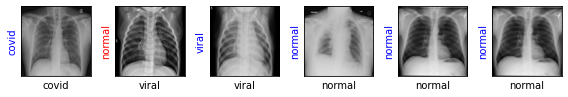

Evaluating at step 100
Val loss: 0.0479, Acc: 0.9967


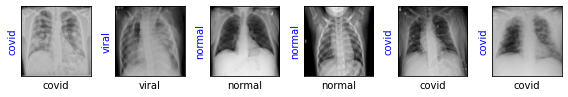

Performance condition has been satisfied


In [ ]:
train(epochs=10)

# Final Results

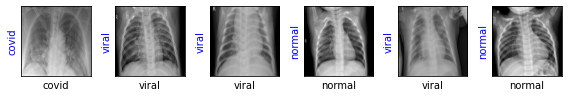

In [ ]:
show_preds()